In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from geopy.distance import geodesic
import shapely.speedups
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.engine import connectivity

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Saves aggregated bus and short-distance rail network.
## Needs PT networks.

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
bus = stepmodel.read_json(input_path + 'de_pt_network_bus')

In [4]:
sm = stepmodel.read_json(input_path + 'de_pt_network')

In [5]:
# Make sure to use the right zones
z = stepmodel.read_json(model_path + 'de_zones')
z.zones['FID'] = z.zones['NUTS_ID']
sm.zones = z.zones
bus.zones = z.zones

In [6]:
# FIRST: Set time of free-rider links
# Default velocity of 14 m/s for rail links
sm.links.loc[sm.links['time']==0, 'time'] = sm.links.loc[
    sm.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 14
# 8 m/s for bus links
bus.links.loc[bus.links['time']==0, 'time'] = bus.links.loc[
    bus.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 8

In [7]:
print(len(sm.links.loc[sm.links['time']==0]))
print(len(bus.links.loc[bus.links['time']==0]))

1
478


## Test links and nodes for network integrity
Neccessary for any further steps

In [8]:
# Check nodeset integrity for later steps to work
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Found {} orphan nodes'.format(len(sm.orphan_nodes)))
    sm.nodes.drop(sm.orphan_nodes, inplace=True)
    # Test integrity again
    sm.integrity_test_nodeset_consistency()

Found 5 orphan nodes
no road_links or road_nodes


In [9]:
# Test sequences
# Use an own function because quetzal's takes ages
def test_sequences(trip):
    assert len(trip)==trip['link_sequence'].max(), \
        'broken sequence in trip {}'.format(trip['trip_id'].unique()[0])

In [10]:
# Fix sequences
# Use an own function because quetzal's takes ages
def fix_sequences(trip):
    trip = trip.sort_values('link_sequence')
    # Check link succession
    ind = list(trip.index)
    for i in range(len(trip.index) - 1):
        try:
            assert trip.loc[ind[i], 'b'] == trip.loc[ind[i+1], 'a'], \
                'broken trip {}: stop {} has no successor link'.format(
                    trip['trip_id'].unique()[0], trip.loc[ind[i], 'b'])
        except AssertionError:
            trip.loc[ind[i+1]:ind[-1], 'trip_id'] = \
                trip.loc[ind[i+1]:ind[-1], 'trip_id'] + '_' + str(i)
    # Repair sequences
    if len(trip) != trip['link_sequence'].max():
        trip['link_sequence'] = trip.groupby('trip_id')['link_sequence'].apply(
            lambda t: [j for j in range(1, len(t.index)+1)]).sum()
    return trip

In [11]:
# Test and save broken sequences
def test_sequences_save(trip):
    if len(trip)!=trip['link_sequence'].max():
        return list(trip.index)

In [12]:
tqdm.pandas()
try:
    sm.links.groupby('trip_id').progress_apply(test_sequences)
except AssertionError:
    links = sm.links.groupby('trip_id').progress_apply(fix_sequences).reset_index(level=0, drop=True)
    links.groupby('trip_id').progress_apply(test_sequences)
    sm.links = links

100%|██████████████████████████████████████████████████████████████████████████| 21118/21118 [00:07<00:00, 2833.70it/s]


In [13]:
try:
    bus.links.groupby('trip_id').progress_apply(test_sequences)
except AssertionError:
    broken_seqs = bus.links.groupby('trip_id').progress_apply(test_sequences_save)
    links = bus.links.loc[broken_seqs.loc[broken_seqs.notna()].sum()
                         ].groupby('trip_id').progress_apply(fix_sequences)
    links.reset_index(level=0, drop=True, inplace=True)
    links.groupby('trip_id').progress_apply(test_sequences)
    bus.links = bus.links.drop(broken_seqs.loc[broken_seqs.notna()].sum()).append(links)

100%|████████████████████████████████████████████████████████████████████████| 212259/212259 [01:22<00:00, 2573.49it/s]


In [14]:
bus.links.sample()

,route_id,route_type,a,b,time,trip_id,link_sequence,geometry
index,,,,,,,,
bus_821629,bus_13578,bus,bus_n_124080,bus_n_270668,60.0,bus_120793,3,"LINESTRING (8.30727 50.67987, 8.31007 50.67802)"


In [15]:
bus.nodes.sample()

,stop_name,route_type,geometry
index,,,
bus_x_n_190813,Krummenerl Plate & Stremmel,bus,POINT (7.75217 51.07693)


In [16]:
sm.links.loc[sm.links.duplicated(['a', 'b', 'trip_id'], keep=False)]

,a,b,link_sequence,route_id,route_type,time,trip_id,geometry
index,,,,,,,,


## Map nodes to zones
Needed for clustering

In [17]:
# Nodes must be a GeoDataFrame
sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
shapely.speedups.enable()
sm.nodes['FID'] = np.nan
for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
    sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [00:40<00:00,  9.98it/s]


In [18]:
bus.nodes = gpd.GeoDataFrame(bus.nodes, crs=sm.epsg)
bus.nodes['FID'] = np.nan
for _, zone in tqdm(bus.zones.iterrows(), total=bus.zones.shape[0]):
    bus.nodes.loc[bus.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [17:47<00:00,  2.66s/it]


In [19]:
# Drop nodes outside of zones
sm.nodes = sm.nodes[sm.nodes['FID'].notna()]
bus.nodes = bus.nodes[bus.nodes['FID'].notna()]
print(sm.nodes.shape)
print(bus.nodes.shape)

(15376, 4)
(413714, 4)


## Divide links and nodes
Long-distance nodes don't need to be clustered due to relatively small numbers, while bus and rail short-distance services have a high geographic coverage.

In [20]:
# Divide nodes
print(sm.nodes.shape)
disagg_nodes = sm.nodes.loc[sm.nodes['route_type']=='rail_short_distance'].append(bus.nodes)
sm.nodes = sm.nodes.loc[sm.nodes['route_type']!='rail_short_distance']
print(disagg_nodes.shape)

(15376, 4)
(427727, 4)


In [21]:
# Divide links
print(sm.links.shape)
disagg_links = sm.links.loc[sm.links['route_type']=='rail_short_distance'].append(bus.links)
sm.links = sm.links.loc[sm.links['route_type']!='rail_short_distance']
print(disagg_links.shape)

(213129, 8)
(3392365, 8)


In [22]:
# Number of trips
len(disagg_links['trip_id'].unique())

227239

## Cluster stops
Bus and short-distance rail service in the GTFS feeds contain a lot of intermediate stops which can be clustered

In [23]:
# Cluster nodes by zone and route_type
nodes = []
parenthood = []
clusters = []
links = []
for z in tqdm(disagg_nodes['FID'].unique(), total=len(sm.zones)):
    for t in disagg_nodes.loc[disagg_nodes['FID']==z, 'route_type'].unique():
        n = disagg_nodes.loc[(disagg_nodes['route_type']==t) & (disagg_nodes['FID']==z)]
        n_clusters = min(5, max(1, len(sm.nodes.loc[ # Max 5, min 1 cluster
            (sm.nodes['FID']==z) & (sm.nodes['route_type'].isin(['rail_long_distance', 'air']))])))
        n_clusters = min(len(n), n_clusters)
        if n_clusters < 1:
            continue
        l, centroids, node_clusters, node_parenthood = connectivity.node_clustering(
            disagg_links.loc[(disagg_links['a'].isin(n.index)) &
                             (disagg_links['b'].isin(n.index))], n, n_clusters)
        nodes.append(centroids)
        parenthood.append(node_parenthood)
        clusters.append(node_clusters)
        links.append(l)

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [11:23<00:00,  1.70s/it]


<AxesSubplot:>

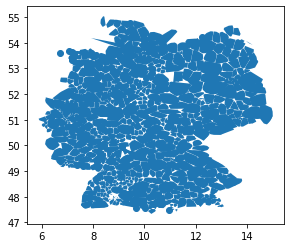

In [24]:
# Coverage
gpd.GeoDataFrame(pd.concat(clusters), crs=sm.epsg).plot()

In [25]:
# Number of zones with short-distance PT connection
len(pd.concat(parenthood)['FID'].unique())

401

In [26]:
# Merge node clusters by group (zone and route_type)
agg_nodes = []
for i in range(len(nodes)):
    agg = gpd.GeoDataFrame(nodes[i], crs=sm.epsg)
    agg.index = agg.index.astype(int)
    agg = agg.merge(parenthood[i][['FID', 'route_type', 'cluster']].drop_duplicates(),
        how='left', left_index=True, right_on='cluster')
    agg.index = agg['FID'] + '_' + agg['route_type'] + '_' + agg['cluster'].astype(str)
    agg_nodes.append(agg)

In [27]:
agg_nodes = gpd.GeoDataFrame(pd.concat(agg_nodes), crs=sm.epsg)
agg_nodes.sample(2)

,geometry,FID,route_type,cluster
DEB37_bus_0,POINT (7.58868 49.19856),DEB37,bus,0
DE40I_bus_0,POINT (13.87206 53.28218),DE40I,bus,0


In [28]:
print(agg_nodes.loc[agg_nodes['route_type']=='bus'].shape)
print(agg_nodes.loc[agg_nodes['route_type']!='bus'].shape)

(865, 4)
(849, 4)


### Aggregate links within the clustered trips

<AxesSubplot:>

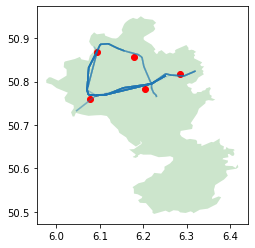

In [29]:
# Example: rail short-distance around Aachen
gpd.GeoDataFrame(links[0]).plot(alpha=.1,ax=gpd.GeoDataFrame(nodes[0]).plot(
    color='r', ax=gpd.GeoDataFrame(sm.zones.loc['DEA2D']).T.plot(color='g', alpha=.2)))

In [201]:
def aggregate_links(links, parents):
    links = links.sort_values(['trip_id', 'link_sequence'])
    l = links.loc[links['a']!=links['b']].copy()
    if len(l) == 0:
        return # Cluster is fully irrelevant
    # Correct geometry
    c_dict = parents.groupby('cluster').first()['geometry_centroid'].to_dict()
    l['geometry'] = [geometry.LineString([c_dict[int(a)], c_dict[int(b)]])
                     for a, b in zip(l['a'], l['b'])]
    # Set a distance
    l['length'] = l['geometry'].apply(lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))
    '''# Aggregate time: average inner-cluster time
    # between every cluster node, because every node has centroid connection
    t_dict = {trip: l.loc[l['trip_id']==trip, 'time'].sum()/len(
                l.loc[l['trip_id']==trip][['a', 'b']].stack().unique())
              for trip in l['trip_id'].unique()}
    l['time'] = l['trip_id'].map(t_dict).astype(int)'''
    # Aggregate time: sum up time until that stop
    def within_time(trip):
        ident = trip['trip_id'].unique()[0]
        times = []
        prev_seq = 0
        for seq in trip['link_sequence']:
            times.append(int(links.loc[
                (links['link_sequence']>prev_seq) &
                (links['link_sequence']<=seq) &
                (links['trip_id']==ident), 'time'].sum()))
            prev_seq = seq
        l.loc[l['trip_id']==ident, 'time'] = times
    l.groupby('trip_id').apply(within_time)
    # Rename a and b as in agg_nodes
    prefix = parents['FID'].unique()[0] + '_' + parents['route_type'].unique()[0] + '_'
    l['a'] = prefix + l['a']
    l['b'] = prefix + l['b']
    return l

In [202]:
agg_links = []
for i in tqdm(range(len(links)), total=len(links)):
    l = aggregate_links(links[i], parenthood[i])
    if l is not None:
        agg_links.append(l)

100%|████████████████████████████████████████████████████████████████████████████████| 802/802 [05:51<00:00,  2.28it/s]


<AxesSubplot:>

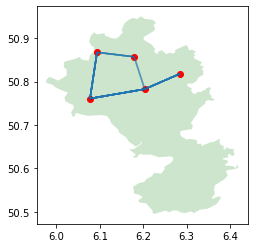

In [32]:
# Example: rail short-distance around Aachen
gpd.GeoDataFrame(agg_links[0]).plot(
    alpha=.1,ax=gpd.GeoDataFrame(nodes[0]).plot(
        color='r', ax=gpd.GeoDataFrame(sm.zones.loc['DEA2D']).T.plot(color='g', alpha=.2)))

In [203]:
agg_links = pd.concat(agg_links)
agg_links.drop(['disaggregated_a', 'disaggregated_b'], axis=1, inplace=True)
agg_links.sample(2)

,a,b,geometry,link_sequence,route_id,route_type,time,trip_id,length
index,,,,,,,,,
bus_2327338,DE232_bus_0,DE232_bus_1,LINESTRING (12.14129366863001 49.0147115782724...,55.0,bus_14710,bus,360.0,bus_721231,6700
bus_476351,DEA42_bus_1,DEA42_bus_0,LINESTRING (8.249604793600662 51.9909090453516...,2.0,bus_1945,bus,300.0,bus_51608,25871


In [204]:
len(agg_links)

73574

In [205]:
# Set a minimum time of one minute
print(len(agg_links.loc[agg_links['time']==0]))
agg_links.loc[agg_links['time']==0, 'time'] = 60

0


<AxesSubplot:>

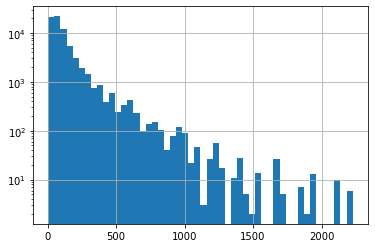

In [206]:
# Speed distribution [km/h]
mask = agg_links['time']>60 # They skew the picture
(agg_links.loc[mask,'length']/1000 / (agg_links.loc[mask,'time']/3600)).hist(bins=50, log=True)

### Prepare the inter-zonal links

In [207]:
# Filter inter-zonal links
parents = pd.concat(parenthood)
inter_links = disagg_links.drop(pd.concat(links).index)
len(inter_links)

94565

In [208]:
inter_links = inter_links.loc[(inter_links['a'].isin(parents.index)) &
                              (inter_links['b'].isin(parents.index))]
len(inter_links)

93712

In [209]:
# Generate dictionary with old and new node indicies
parents['node_name'] = parents['FID'] + '_' + \
    parents['route_type'] + '_' + parents['cluster'].astype(str)
node_dict = parents['node_name'].to_dict()

In [210]:
# Replace old node indicies with new ones
inter_links['a'] = inter_links['a'].map(node_dict)
inter_links['b'] = inter_links['b'].map(node_dict)

In [211]:
# Any issues?
inter_links.loc[(inter_links['a']==inter_links['b'])|(inter_links['a'].isna())|(inter_links['b'].isna())]

,a,b,geometry,link_sequence,route_id,route_type,time,trip_id,length
index,,,,,,,,,


In [212]:
# Correct geometry
geo_dict = parents.groupby('node_name').first()['geometry_centroid'].to_dict()
inter_links['geometry'] = [geometry.LineString([geo_dict[a], geo_dict[b]])
                           for a,b in zip(inter_links['a'], inter_links['b'])]

In [213]:
# Add length
inter_links['length'] = inter_links['geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

In [134]:
'''# Preparation to set time
zone_dict = agg_nodes['FID'].to_dict()
inter_links['origin'] = inter_links['a'].map(zone_dict)
inter_links['destination'] = inter_links['b'].map(zone_dict)
agg_links['origin'] = agg_links['a'].map(zone_dict)
time_dict = agg_links.groupby(['origin', 'trip_id']).agg({'time': 'sum'}).to_dict()['time']

# Add half the cluster times of origin zone by trip
inter_links['time'] += [int(time_dict[(z,t)] / 2) if (z,t) in time_dict.keys() else 0
                        for z,t in zip(inter_links['origin'], inter_links['trip_id'])]
# Add half the cluster times of destination zone by trip
inter_links['time'] += [int(time_dict[(z,t)] / 2) if (z,t) in time_dict.keys() else 0
                        for z,t in zip(inter_links['destination'], inter_links['trip_id'])]'''
print('Deprected')

In [ ]:
# Adjust times: Add missing trip time ontop of inter-zonal links
time_dict = disagg_links.groupby('trip_id').agg({'time': 'sum'}).to_dict()['time']
def adjust_times(trip):
    ident = trip['trip_id'].unique()[0]
    mask = inter_links['trip_id']==ident
    if len(inter_links.loc[mask]) > 0:
        diff = time_dict[ident] - trip['time'].sum()
        inter_links.loc[mask, 'time'] += int(diff / len(inter_links.loc[mask]))
pd.concat([agg_links, inter_links]).groupby('trip_id').progress_apply(adjust_times)

In [231]:
inter_links.sample()

,a,b,geometry,link_sequence,route_id,route_type,time,trip_id,length
index,,,,,,,,,
rail_short_180998,DEA54_rail_short_distance_2,DEA38_rail_short_distance_0,"LINESTRING (7.831551 51.709194, 7.891636674041...",3.0,rail_short_54,rail_short_distance,400.0,rail_short_57050,21511


<AxesSubplot:>

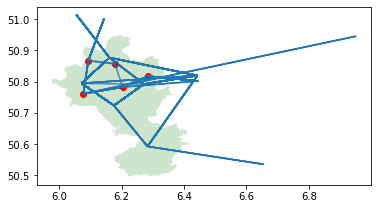

In [142]:
# Example: short-distance around Aachen
gpd.GeoDataFrame(inter_links.loc[inter_links['b'].isin(agg_nodes.loc[agg_nodes['FID']=='DEA2D'].index)]).plot(
    ax=gpd.GeoDataFrame(agg_links.loc[agg_links['a'].isin(agg_nodes.loc[agg_nodes['FID']=='DEA2D'].index)]).plot(
        alpha=.1,ax=gpd.GeoDataFrame(nodes[0]).plot(
            color='r', ax=gpd.GeoDataFrame(sm.zones.loc['DEA2D']).T.plot(color='g', alpha=.2))))

<AxesSubplot:>

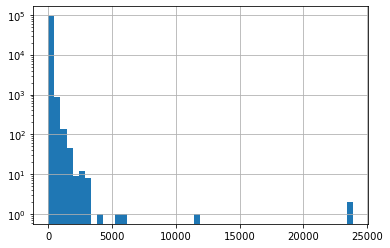

In [232]:
# Speed distribution [km/h]
mask = inter_links['time']>60 # They skew the picture
(inter_links.loc[mask,'length']/1000 / (inter_links.loc[mask,'time']/3600)).hist(bins=50, log=True)

### Concatenate links

In [233]:
# Concat links
agg_links = pd.concat([agg_links, inter_links])
#agg_links.drop(['origin', 'destination'], axis=1, errors='ignore', inplace=True)
len(agg_links)

167286

In [239]:
# Remove trips that are only within one zone
def filter_od(trip):
    o = list(trip['a'].str[:3])
    d = list(trip['b'].str[:3])
    if len(set(o+d)) > 1:
        return True
    else:
        return False
relevant = agg_links.groupby('trip_id').apply(filter_od).to_dict()

In [242]:
agg_links = agg_links.loc[agg_links['trip_id'].map(relevant)]
len(agg_links)

126359

In [243]:
# Re-index sequence numbers
agg_links = agg_links.sort_values(['trip_id', 'link_sequence'])
agg_links['link_sequence'] = sum([list(range(1, count+1)) for count in
                                  agg_links.groupby('trip_id').count()['a']], [])

In [244]:
# Validation
# Are trip times the same among clustered and original links?
merged = agg_links.groupby('trip_id').agg({'time': 'sum'}).merge(
    disagg_links.loc[disagg_links['trip_id'].isin(agg_links['trip_id'])
                    ].groupby('trip_id').agg({'time': 'sum'}),
    how='left', left_index=True, right_index=True, suffixes=['_agg', '_disagg'])
merged['time_agg'] /= 3600
merged['time_disagg'] /= 3600

<AxesSubplot:>

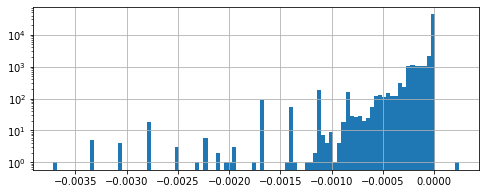

In [245]:
# Difference in hours per trip_id
(merged['time_agg'] - merged['time_disagg']).hist(
    bins=100, log=True, figsize=(8,3))

In [246]:
# Total time reduction through clustering [h]
mask = disagg_links['trip_id'].isin(agg_links['trip_id'])
(disagg_links.loc[mask, 'time'].sum() - agg_links['time'].sum()) / 3600

2.417455357147588

<AxesSubplot:>

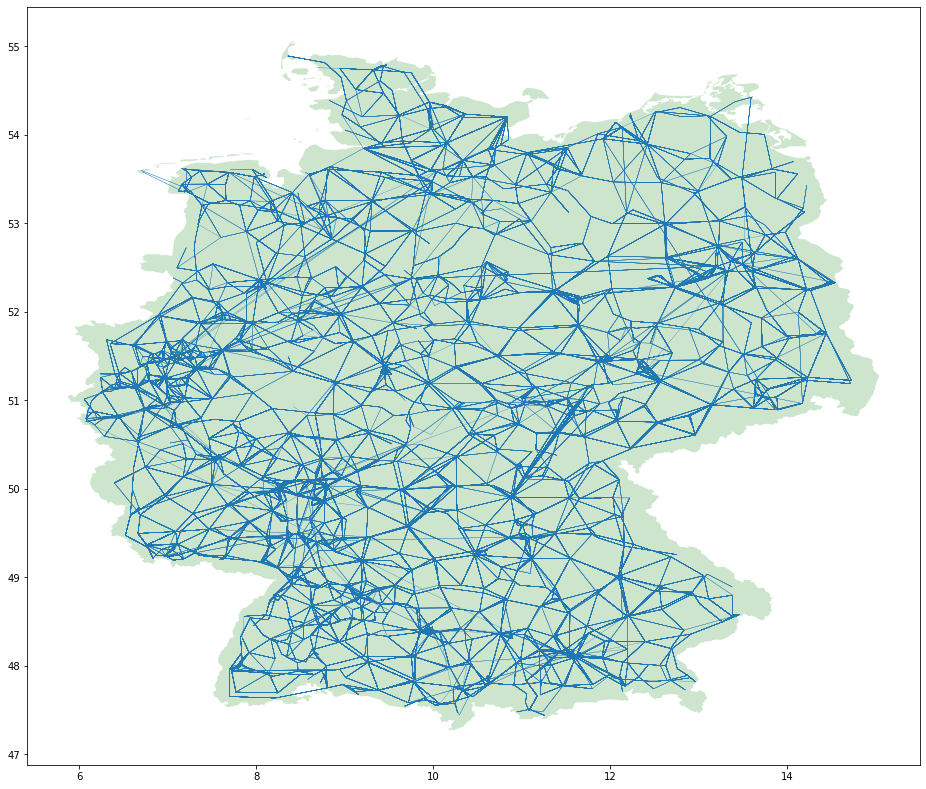

In [249]:
gpd.GeoDataFrame(agg_links, crs=sm.epsg).plot(
    linewidth=.3, ax=gpd.GeoDataFrame(sm.zones, crs=sm.epsg).plot(
        alpha=.2, color='green', figsize=(16,16)))

## Merge aggregated links and nodes with the model

In [250]:
# Generate length for long-distance nodes
sm.links['length'] = sm.links['geometry'].apply(
    lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

In [251]:
# Re-add links to model
sm.links = sm.links.append(agg_links)
sm.links.shape

(158297, 9)

In [252]:
# Re-add nodes to the model
sm.nodes = sm.nodes.append(agg_nodes)
sm.nodes.shape

(3077, 5)

In [253]:
# Drop cluster column
sm.nodes.drop('cluster', axis=1, inplace=True)

In [254]:
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Number of orphan nodes: {}'.format(
        len(sm.orphan_nodes)))
    print('Number of missing nodes: {}'.format(
        len(sm.missing_nodes)))

Number of orphan nodes: 0
Number of missing nodes: 3


In [255]:
sm.links.groupby('trip_id').apply(test_sequences)

""


In [256]:
len(sm.links.loc[sm.links.isna().any(axis=1)])

0

In [257]:
# Drop routes of unused links
sm.pt_routes = sm.pt_routes.loc[sm.links['route_id'].unique()]
sm.pt_routes.shape

(5770, 9)

In [258]:
# Drop routes of unused bus links
bus.pt_routes = bus.pt_routes.loc[sm.links['route_id'].unique()]
bus.pt_routes.shape

(5770, 5)

## Save model


In [259]:
# Add bus service to ancilliary
sm.agencies = sm.agencies.append(bus.agencies).reset_index(drop=True)
sm.pt_routes = sm.pt_routes.append(bus.pt_routes).reset_index(drop=True)

In [260]:
# Now, we have bus services in the same tables
sm.pt_route_types = list(sm.links['route_type'].unique())
sm.pt_route_types

['rail_long_distance',
 'coach',
 'air',
 'bus',
 'subway',
 'ferry',
 'funicular',
 'rail_short_distance']

In [261]:
# Reduce file size by shortening node index names
sm.nodes['index'] = [i.replace('rail_short_distance', 'r_s') for i in sm.nodes.index]
sm.nodes.set_index('index', drop=True, inplace=True)
sm.links['a'] = sm.links['a'].apply(lambda n: n.replace('rail_short_distance', 'r_s'))
sm.links['b'] = sm.links['b'].apply(lambda n: n.replace('rail_short_distance', 'r_s'))

In [262]:
sm.nodes['index'] = [i.replace('rail_long_n', 'r_l_n') for i in sm.nodes.index]
sm.nodes.set_index('index', drop=True, inplace=True)
sm.links['a'] = sm.links['a'].apply(lambda n: n.replace('rail_long_n', 'r_l_n'))
sm.links['b'] = sm.links['b'].apply(lambda n: n.replace('rail_long_n', 'r_l_n'))

In [263]:
# Shorten link index names
sm.links['index'] = [i.replace('rail_long', 'r_l').replace('rail_short', 'r_s')
                     for i in sm.links.index]
sm.links.set_index('index', drop=True, inplace=True)

In [264]:
# Shorten route type names
type_dict = {'rail_short_distance': 'rail_short', 'rail_long_distance': 'rail_long'}
sm.links['route_type'] = sm.links['route_type'].replace(type_dict)
sm.nodes['route_type'] = sm.nodes['route_type'].replace(type_dict)
sm.pt_route_types = [t.replace('_distance', '') for t in sm.pt_route_types]

In [265]:
sm.links.loc[sm.links['route_type']=='rail_short'].sample()

,a,b,geometry,length,link_sequence,route_id,route_type,time,trip_id
index,,,,,,,,,
r_s_138607,DE713_r_s_0,DE712_r_s_2,"LINESTRING (8.78140 50.09740, 8.67230 50.10442)",12090,2.0,rail_short_31,rail_short,615.0,rail_short_37694


In [266]:
# Cast columns to integer
cols = ['length', 'link_sequence', 'time']
sm.links[cols] = sm.links[cols].astype(int)

In [267]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [268]:
sm.links.shape

(158297, 5)

In [269]:
# Saving model...
sm.to_json(model_path + 'de_pt_network_agg',
           only_attributes=['zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')



to_hdf(overwriting):   0%|                                                                      | 0/38 [00:00<?, ?it/s]

to_hdf(overwriting):  24%|██████████████▋                                               | 9/38 [00:21<01:07,  2.34s/it]

to_hdf(overwriting):  55%|█████████████████████████████████▋                           | 21/38 [00:21<00:28,  1.65s/it]

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:22<00:00,  1.67it/s]


In [270]:
sm.to_json(model_path + 'de_pt_network_ancillary',
           only_attributes=['agencies', 'pt_routes'],
           encoding='utf-8')



to_hdf(overwriting):   0%|                                                                      | 0/38 [00:00<?, ?it/s]

to_hdf(overwriting): 100%|████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 379.34it/s]


In [271]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')

In [272]:
# Save the node dictionary
node_dict = {k: v.replace('rail_short_distance', 'r_s').replace('rail_long_distance', 'r_l')
             for k, v in node_dict.items()}
with open(input_path + 'de_pt_network_frequencies/clustering_dict.json', 'w') as f:
    json.dump(node_dict, f)

## Merge frequencies

The frequency files are too large to be loaded into a 8GB RAM together with the networks. Thus, they are handled afterwards, seperately.

In [283]:
bus = None
sm.links[cols] = auxiliary.set_index('index')[cols]

In [5]:
# In case your kernel restarted: Load aggregation results
#sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
#with open(input_path + 'de_pt_network_frequencies/clustering_dict.json', 'r') as f:
#    node_dict = json.load(f)

In [274]:
# Load frequencies
bus_frequencies = pd.read_json(input_path + 'de_pt_network_frequencies/frequencies_bus.json')
pt_frequencies = pd.read_json(input_path + 'de_pt_network_frequencies/frequencies_pt.json')

In [275]:
# Drop duplicate index column
pt_frequencies.drop('index', axis=1, errors='ignore', inplace=True)
bus_frequencies.drop('index', axis=1, errors='ignore', inplace=True)

In [276]:
print(pt_frequencies.shape)
pt_frequencies.sample()

(42359, 3)


,hour,route_id,stop_id
38038,[9],coach_FLIXBUS:1200,coach_n_FLIXBUS:33921


In [277]:
print(bus_frequencies.shape)
bus_frequencies.sample()

(874298, 3)


,stop_id,route_id,hour
506780,bus_n_245573,bus_11084,"[15, 12, 13, 19, 11, 13, 16]"


In [278]:
# Map stops to new clusters and keep non-clustered stops
pt_frequencies['stop_id'] = pt_frequencies['stop_id'].replace(node_dict)

In [279]:
# Map all bus stops to clusters
bus_frequencies['stop_id'] = bus_frequencies['stop_id'].map(node_dict)

In [280]:
len(bus_frequencies.loc[bus_frequencies.isna().any(axis=1)])

19282

In [285]:
# Drop frequencies of unused nodes and links
frequencies = pt_frequencies.loc[
    (pt_frequencies['stop_id'].isin(sm.nodes.index)) &
    (pt_frequencies['route_id'].isin(sm.links['route_id']))]

In [286]:
# Add bus
frequencies = frequencies.append(bus_frequencies.loc[
    (bus_frequencies['stop_id'].isin(sm.nodes.index)) &
    (bus_frequencies['route_id'].isin(sm.links['route_id']))
]).reset_index(drop=True)

In [287]:
frequencies.shape

(329782, 3)

In [288]:
frequencies.loc[frequencies.isna().any(axis=1)]

,hour,route_id,stop_id


In [289]:
# Group stops anew to merge clustered stops
frequencies = frequencies.groupby(['route_id', 'stop_id']).agg({'hour': 'sum'}).reset_index()
frequencies.shape

(28221, 3)

In [290]:
# Save
frequencies['index'] = frequencies.index
frequencies.to_json(model_path + 'de_pt_network_ancillary/frequencies.json')